### 1. Load and Explore the Data

In [29]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'Segoe UI Emoji'

# --- Load YouTube Data ---
with open("youtube_comments_all_batches_merged.json", "r", encoding="utf-8") as f:
    data = [json.loads(line.strip()) for line in f if line.strip()]

# --- Organize Data ---
dates_by_author = defaultdict(list)
comment_counts = defaultdict(int)
all_dates = []

for comment in data:
    created_at = pd.to_datetime(comment["published_at"])  # Handles 'Z' format
    author = comment["author"]

    dates_by_author[author].append(created_at)
    comment_counts[author] += 1
    all_dates.append(created_at)

# --- Print Stats ---
print("\n📊 Author Statistics:")
for author in sorted(dates_by_author, key=lambda a: comment_counts[a], reverse=True)[:5]:  # top 5
    dates = dates_by_author[author]
    print(f"• {author}: {comment_counts[author]} comments | "
          f"Range: {min(dates).date()} → {max(dates).date()}")

print(f"\n📌 Overall Date Range: {min(all_dates).date()} → {max(all_dates).date()}")
print(f"🧮 Total comments: {len(all_dates)}")


📊 Author Statistics:
• @JeffSu: 1685 comments | Range: 2023-06-20 → 2025-05-22
• @MichaelAutomatesModerator-1: 495 comments | Range: 2025-02-06 → 2025-05-05
• @Chad-Kimball: 389 comments | Range: 2024-07-01 → 2025-05-05
• @LawtonSolutions: 309 comments | Range: 2025-01-10 → 2025-05-19
• @BuildWithAIChannel: 197 comments | Range: 2025-01-31 → 2025-05-12

📌 Overall Date Range: 2022-09-08 → 2025-05-22
🧮 Total comments: 48796


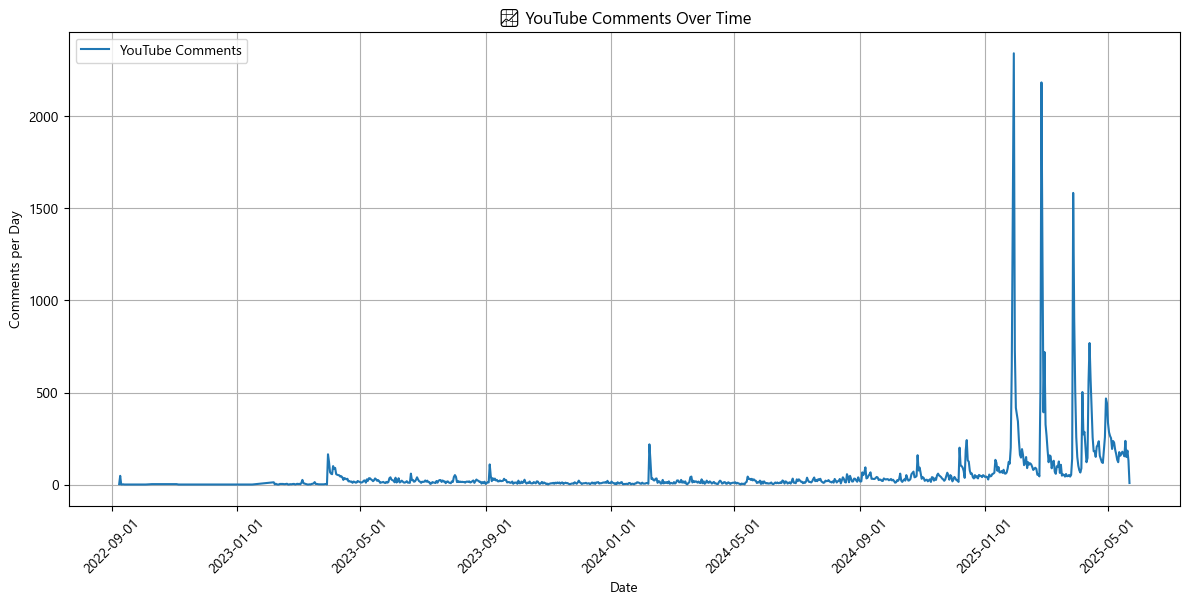

In [2]:
# Create DataFrame for time series
df = pd.DataFrame({
    "author": [c["author"] for c in data],
    "date": [pd.to_datetime(c["published_at"]).date() for c in data]
})
df["date"] = pd.to_datetime(df["date"])

# Plot time series
plt.figure(figsize=(12, 6))
daily_counts = df.groupby("date").size()
plt.plot(daily_counts.index, daily_counts.values, label="YouTube Comments")

plt.xlabel("Date")
plt.ylabel("Comments per Day")
plt.title("📈 YouTube Comments Over Time")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.legend()
plt.show()

### 2. Data preprocessing

In [3]:
import re
import string
import nltk
import unicodedata
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Ensure required resources are available
nltk.download('stopwords')
nltk.download('wordnet')

class YouTubeProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords
        self.regexDigit = re.compile(r"^\d+$")  # match digits only
        self.regexUrl = re.compile(r"(https?://\S+|www\.\S+|\[\S+\])")  # match URLs or [link]-style text
        self.lemmatizer = WordNetLemmatizer()

    def process(self, text):
        # Normalize unicode characters
        text = unicodedata.normalize("NFKD", text)

        # Lowercase
        text = text.lower()

        # Tokenize
        tokens = self.tokeniser.tokenize(text)

        # Filter and lemmatize tokens
        tokensStripped = []
        for tok in tokens:
            tok = tok.strip()
            if (tok not in self.lStopwords and
                self.regexDigit.match(tok) is None and
                self.regexUrl.match(tok) is None and
                len(tok) >= 3):
                lemma = self.lemmatizer.lemmatize(tok)
                tokensStripped.append(lemma)

        return tokensStripped

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Load and Preprocess Data

In [4]:
import json
import pandas as pd
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# File name
youtube_filename = "youtube_comments_all_batches_merged.json"

# Create stopword list
lPunct = list(string.punctuation)
stopwords_list = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`', 'txt', '___']

# Initialize the processor
tokeniser = TweetTokenizer()
ytProcessor = YouTubeProcessing(tokeniser, stopwords_list)

# Load YouTube JSONL file
with open(youtube_filename, 'r', encoding='utf-8') as f:
    youtube_data = [json.loads(line.strip()) for line in f if line.strip()]

# Apply preprocessing to each comment
preprocessed_data = []

for entry in youtube_data:
    tokens = ytProcessor.process(entry['text'])
    date = pd.to_datetime(entry['published_at'])

    preprocessed_data.append({
        "type": "reply" if entry.get("is_reply") else "comment",
        "tokens": tokens,
        "date": date,
        "text": entry['text']
    })

#### Top 50 Words in the Preprocessed Dataset


🔝 Top 50 Words:
video: 6946
like: 5389
prompt: 4186
use: 3837
chatgpt: 3451
make: 3226
model: 3182
get: 3103
work: 3090
people: 3005
one: 2874
thank: 2866
thanks: 2840
time: 2631
would: 2596
know: 2505
great: 2484
using: 2462
need: 2379
much: 2211
think: 2191
thing: 2189
good: 2132
even: 2117
way: 2079
really: 1982
question: 1960
also: 1852
want: 1811
code: 1772
gpt: 1766
human: 1705
help: 1669
see: 1629
better: 1620
tool: 1605
art: 1594
new: 1563
data: 1543
could: 1529
free: 1463
content: 1455
image: 1435
still: 1429
please: 1423
something: 1397
say: 1391
give: 1361
ask: 1343
best: 1313


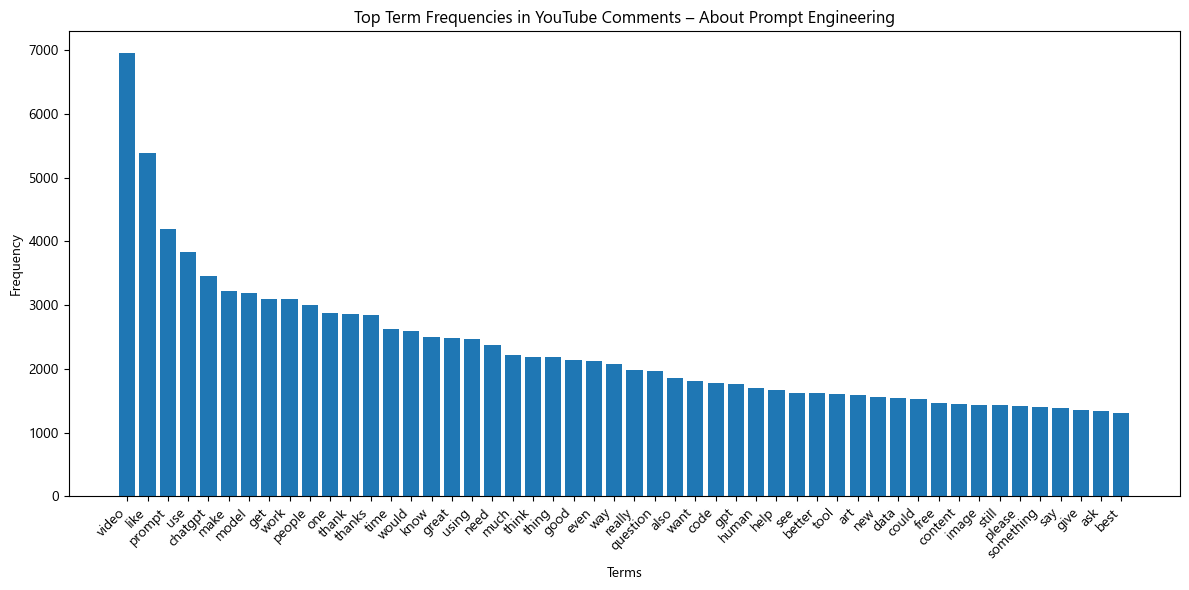

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Set how many words to show
freqNum = 50  
termFreqCounter = Counter()

# Count terms directly from preprocessed tokens
for item in preprocessed_data:
    termFreqCounter.update(item['tokens'])

# Print top terms
print("\n🔝 Top 50 Words:")
for term, count in termFreqCounter.most_common(freqNum):
    print(f"{term}: {count}")

# Prepare for plotting
y = [count for term, count in termFreqCounter.most_common(freqNum)]
x = range(1, len(y) + 1)
terms = [term for term, count in termFreqCounter.most_common(freqNum)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(terms, y)
plt.xticks(rotation=45, ha='right')
plt.title("Top Term Frequencies in YouTube Comments – About Prompt Engineering")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.tight_layout()
plt.show()

### Sentiment Analysis using Vader

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (if not already done)
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define sentiment analysis function
def analyze_sentiment(text):
    return sia.polarity_scores(text)

# Analyze sentiment for each comment
sentiment_results = []

for entry in preprocessed_data:
    text = entry['text']
    sentiment = analyze_sentiment(text)

    sentiment_results.append({
        "type": entry["type"],
        "date": entry["date"],
        "text": text,
        "sentiment_compound": sentiment["compound"],
        "sentiment_pos": sentiment["pos"],
        "sentiment_neu": sentiment["neu"],
        "sentiment_neg": sentiment["neg"]
    })

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\swaya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Time Series of Sentiment

C:\Users\swaya\AppData\Local\Temp\ipykernel_50896\848946144.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_series_sum = series.resample('1H').sum()
C:\Users\swaya\AppData\Local\Temp\ipykernel_50896\848946144.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_series_avg = series.resample('1H').mean()


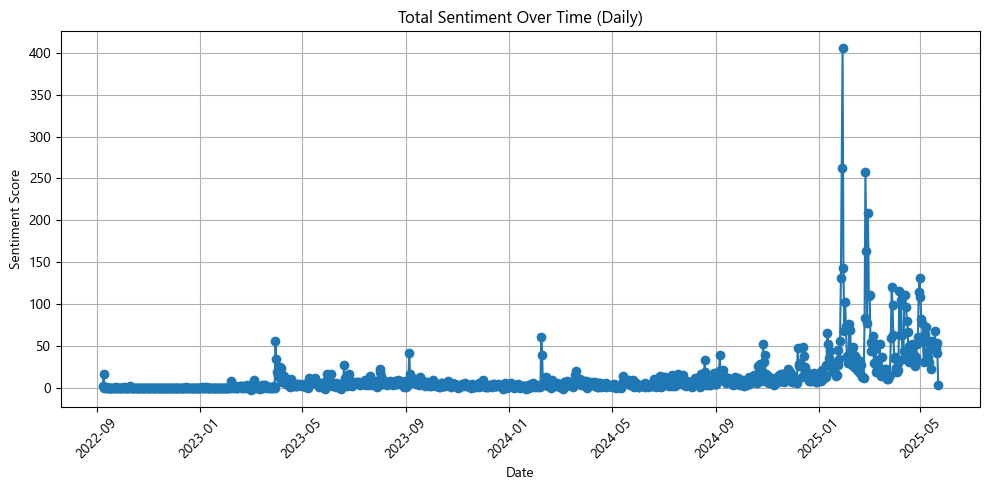

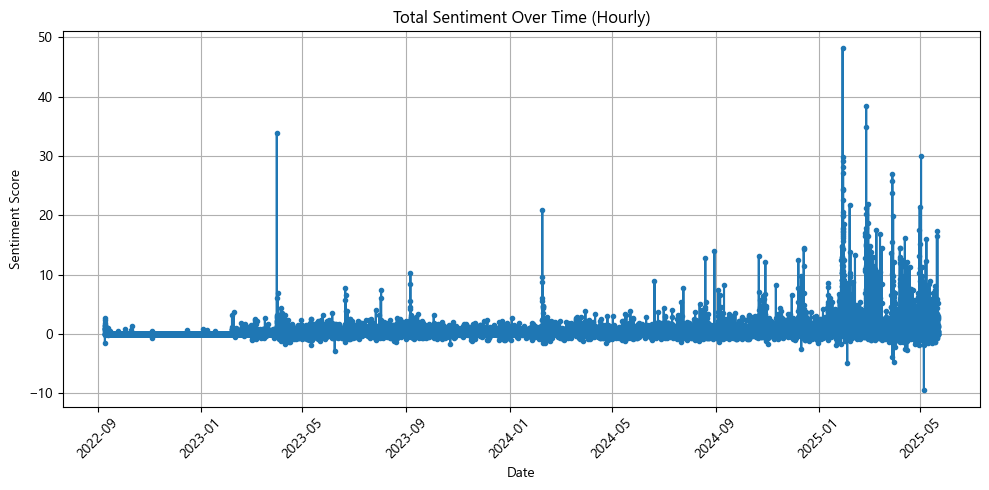

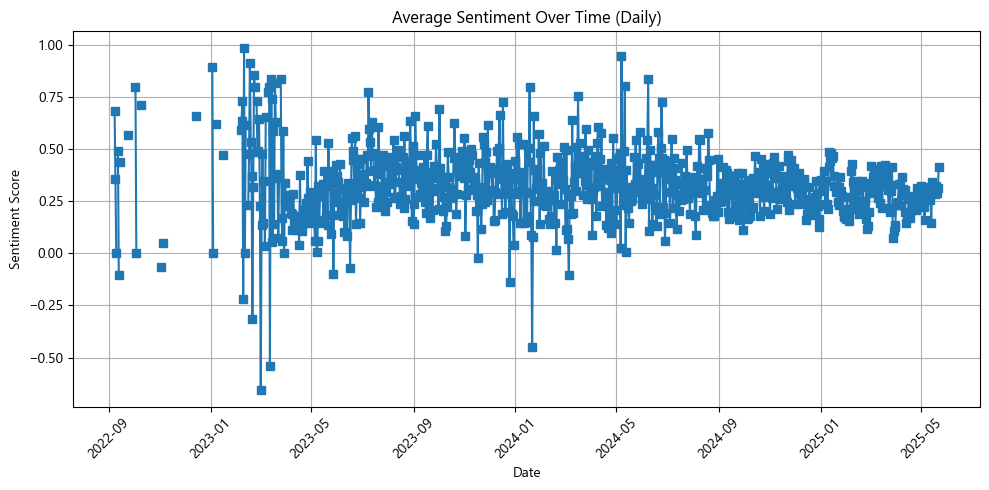

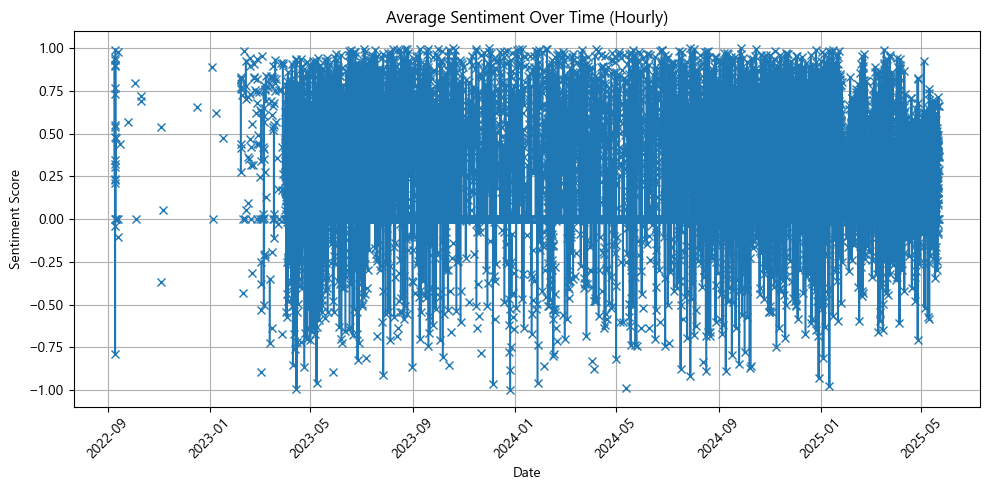

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Build sentiment series
lSentiment = [(entry['date'], entry['sentiment_compound']) for entry in sentiment_results]
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
series.set_index('date', inplace=True)
series['sentiment'] = pd.to_numeric(series['sentiment'])
series.sort_index(inplace=True)

# 1. Total Sentiment Over Time (Daily)
daily_series_sum = series.resample('1D').sum()
plt.figure(figsize=(10, 5))
plt.plot(daily_series_sum.index, daily_series_sum['sentiment'], marker='o')
plt.title("Total Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Total Sentiment Over Time (Hourly)
hourly_series_sum = series.resample('1H').sum()
plt.figure(figsize=(10, 5))
plt.plot(hourly_series_sum.index, hourly_series_sum['sentiment'], marker='.')
plt.title("Total Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Average Sentiment Over Time (Daily)
daily_series_avg = series.resample('1D').mean()
plt.figure(figsize=(10, 5))
plt.plot(daily_series_avg.index, daily_series_avg['sentiment'], marker='s')
plt.title("Average Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 4. Average Sentiment Over Time (Hourly)
hourly_series_avg = series.resample('1H').mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_series_avg.index, hourly_series_avg['sentiment'], marker='x')
plt.title("Average Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show all plots
plt.show()

### Topic Modelling

In [8]:
# Set parameters
topicNum = 5              # Number of topics
wordNumToDisplay = 15     # Words to display per topic
featureNum = 1500         # Vocabulary size

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Join tokens into strings
joined_docs = [' '.join(entry['tokens']) for entry in preprocessed_data]

# Vectorizer
tfVectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=featureNum,
)

# Fit and transform
tf = tfVectorizer.fit_transform(joined_docs)
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

ldaModel = LatentDirichletAllocation(
    n_components=topicNum,
    max_iter=10,
    learning_method='online',
    random_state=42
).fit(tf)

In [11]:
# Display Topics
def display_topics(model, featureNames, numTopWords):
    for topicId, lTopicDist in enumerate(model.components_):
        print(f"\nTopic {topicId + 1}:")
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)


Topic 1:
deepseek open problem result prompt said start source step response watch consume language nice china

Topic 2:
chatgpt video free please gpt use strategy chat using get app help access create link

Topic 3:
like people make think know thing work even one get art would way human time

Topic 4:
model prompt question better data use ask new chatgpt llm answer google learning example lol

Topic 5:
video thank thanks great much love lot agent content really guy amazing good best bro


In [12]:
import pyLDAvis
import pyLDAvis.lda_model  # <— correct path for older versions

# Create and display the panel
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)  # For notebooks

# Or save to HTML if needed:
# pyLDAvis.save_html(panel, "youtube_lda_topics.html")

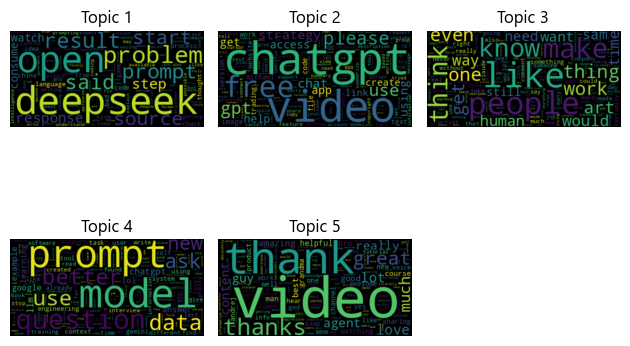

In [13]:
import numpy as np
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def displayWordcloud(model, featureNames):
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    plotColNum = 3
    plotRowNum = int(math.ceil(len(model.components_) / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i]: prob for i, prob in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)

        plt.subplot(plotRowNum, plotColNum, topicId + 1)
        plt.title(f'Topic {topicId + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

displayWordcloud(ldaModel, tfFeatureNames)

### Social Network Analysis: Identifying Influential Users and Structural Properties

In [14]:
import networkx as nx
import json

# Load your full YouTube data (comments + replies)
with open("youtube_comments_all_batches_merged.json", "r", encoding="utf-8") as f:
    youtube_data = [json.loads(line.strip()) for line in f if line.strip()]

# Initialize directed graph
G = nx.DiGraph()

# Add edges for replies only
for item in youtube_data:
    author = item.get("author")
    reply_to = item.get("reply_to")

    # Only add if it's a valid reply between different users
    if item.get("is_reply") and author and reply_to and author != reply_to:
        G.add_edge(author, reply_to)

# Save to GraphML format
nx.write_graphml(G, "youtube_reply_network.graphml", infer_numeric_types=True)
print(f"✅ Saved reply network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

✅ Saved reply network with 14505 nodes and 14450 edges.


In [15]:
import json
import networkx as nx

# Load merged YouTube comment data
with open("youtube_comments_all_batches_merged.json", "r", encoding="utf-8") as f:
    data = [json.loads(line.strip()) for line in f if line.strip()]

# Create a directed graph
G = nx.DiGraph()

# Build edges based on replies
for comment in data:
    author = comment.get("author", "[unknown]")
    reply_to = comment.get("reply_to")  # Only present for replies

    # Skip invalid users or self-replies
    if author and reply_to and author != reply_to and reply_to != "":
        G.add_node(author)
        G.add_node(reply_to)
        G.add_edge(author, reply_to)

# Save graph
output_file = "youtube_reply_network.graphml"
nx.write_graphml(G, output_file, infer_numeric_types=True)

print(f"✅ YouTube reply graph saved as '{output_file}' with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

✅ YouTube reply graph saved as 'youtube_reply_network.graphml' with 14505 nodes and 14450 edges.


In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load your GraphML reply network (previously created)
sFileName = "youtube_reply_network.graphml"
replyGraph = nx.readwrite.read_graphml(sFileName)

In [17]:
# Remove isolated users
isolated_nodes = list(nx.isolates(replyGraph))
replyGraph.remove_nodes_from(isolated_nodes)

# Use weakly connected component (more inclusive)
if not nx.is_weakly_connected(replyGraph):
    largest_wcc = max(nx.weakly_connected_components(replyGraph), key=len)
    replyGraph = replyGraph.subgraph(largest_wcc).copy()

print(f"📌 Remaining nodes: {replyGraph.number_of_nodes()} | edges: {replyGraph.number_of_edges()}")

📌 Remaining nodes: 10731 | edges: 11709


In [18]:
# Centrality Calculations
lDegCentrality = nx.degree_centrality(replyGraph)
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=5000, tol=1e-6)
lKatzCentrality = nx.katz_centrality(replyGraph, alpha=0.005, max_iter=1000, tol=1e-4)

# Display
print("Top 5 users by Degree Centrality:",
      sorted(lDegCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 users by Eigenvector Centrality:",
      sorted(lEigenVectorCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 users by Katz Centrality:",
      sorted(lKatzCentrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 users by Degree Centrality: [('@JeffSu', 0.1477166821994408), ('@MichaelAutomatesModerator-1', 0.04501397949673812), ('@Chad-Kimball', 0.036346691519105315), ('@LawtonSolutions', 0.02777260018639329), ('@BuildWithAIChannel', 0.017427772600186395)]
Top 5 users by Eigenvector Centrality: [('@JeffSu', 0.0676219841913267), ('@Captinofthemudslayer', 0.04853280614816989), ('@stepstogrow1', 0.04488196420211278), ('@mihealingarts4986', 0.04488192459448919), ('@Titty_suckerr', 0.04488192459448919)]
Top 5 users by Katz Centrality: [('@lambdaprog', 0.017703912760509446), ('@riverland0072', 0.017079636710393416), ('@kirkshanghai', 0.016124611050916084), ('@bob-p7x6j', 0.015458114121677205), ('@Ritikprivatelimited', 0.015352467774535899)]


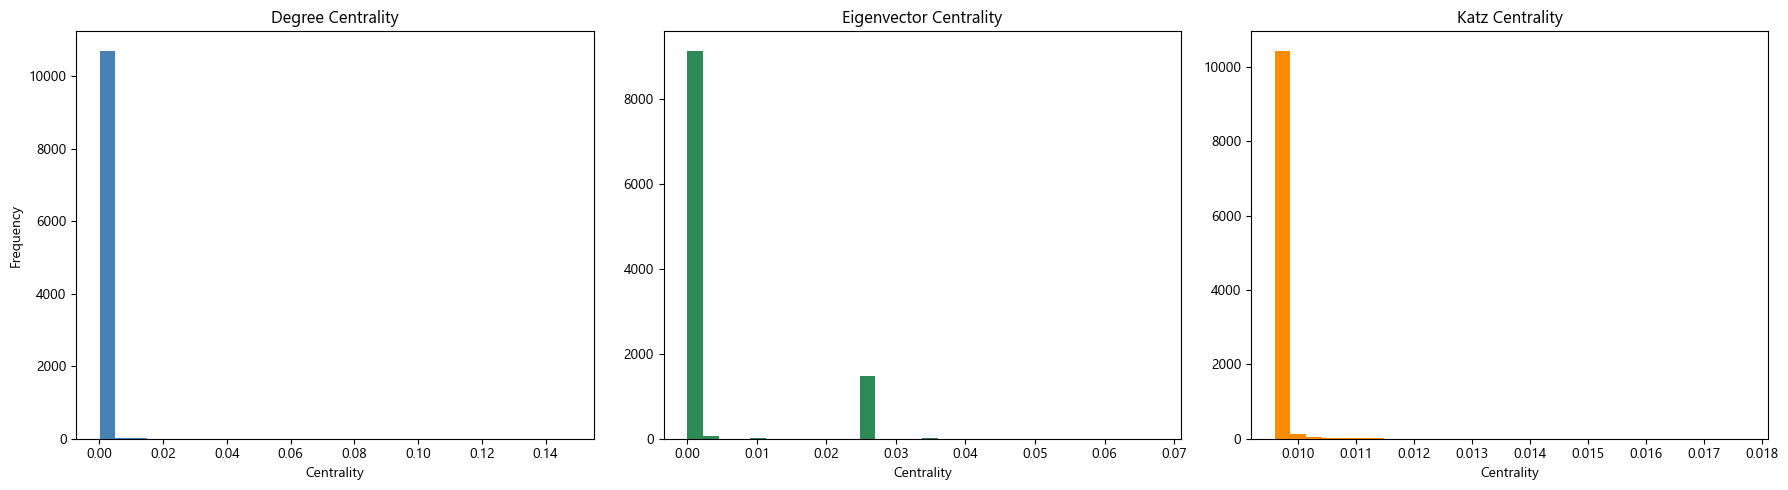

In [19]:
# Visualize distribution of centrality scores including Katz
plt.figure(figsize=(18, 5))

# Degree Centrality
plt.subplot(1, 3, 1)
plt.hist(list(lDegCentrality.values()), bins=30, color='steelblue')
plt.title('Degree Centrality')
plt.xlabel('Centrality')
plt.ylabel('Frequency')

# Eigenvector Centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()), bins=30, color='seagreen')
plt.title('Eigenvector Centrality')
plt.xlabel('Centrality')

# Katz Centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()), bins=30, color='darkorange')
plt.title('Katz Centrality')
plt.xlabel('Centrality')

plt.tight_layout()
plt.show()

In [20]:
# Add centrality scores as node attributes
for nodeId, val in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(val)

# Save modified network
nx.write_graphml(replyGraph, 'mod_' + sFileName, infer_numeric_types=True)

In [27]:
print('Global clustering coefficient (transitivity):', nx.transitivity(replyGraph))
print('Number of strongly connected components:', nx.number_strongly_connected_components(replyGraph))
print('Number of weakly connected components:', nx.number_weakly_connected_components(replyGraph))

Global clustering coefficient (transitivity): 5.7056050437548585e-05
Number of strongly connected components: 10718
Number of weakly connected components: 1


In [22]:
# Find bridge edges in the undirected version of the graph
bridges = list(nx.bridges(replyGraph.to_undirected()))
print(f"Bridges found ({len(bridges)}):", bridges)

Bridges found (9444): [('@MakingPhoto', '@DrNothing23'), ('@MakingPhoto', '@KingJamesBibleArt'), ('@MakingPhoto', '@moodfoodmusic7355'), ('@MakingPhoto', '@annavoinova7396'), ('@MakingPhoto', '@Bartetmedia'), ('@MakingPhoto', '@GoapprStudios'), ('@MakingPhoto', '@adrewbateman1760'), ('@MakingPhoto', '@fruitlessbeast'), ('@MakingPhoto', '@lost13559'), ('@MakingPhoto', '@jsbadger'), ('@MakingPhoto', '@chrisangelobiz'), ('@MakingPhoto', '@KrazyMO'), ('@MakingPhoto', '@Annur375'), ('@MakingPhoto', '@olehsavchuk3189'), ('@MakingPhoto', '@cryptojedii'), ('@MakingPhoto', '@yutube3799'), ('@MakingPhoto', '@vastadmist2258'), ('@MakingPhoto', '@TehCacti'), ('@MakingPhoto', '@shankerm3959'), ('@MakingPhoto', '@HMaxTube11'), ('@MakingPhoto', '@MsJamiePBD'), ('@MakingPhoto', '@ralphprice7365'), ('@MakingPhoto', '@wolfai_'), ('@MakingPhoto', '@yoavalvin'), ('@MakingPhoto', '@ryanhowell4492'), ('@MakingPhoto', '@shadedlightdigital'), ('@MakingPhoto', '@alexandersorbas1881'), ('@MakingPhoto', '@sneh93

### Random Cascade

In [30]:
# COSC2671 Workshop 10 – Independent Cascade on YouTube Reply Network

import time
import random
import numpy as np
import networkx as nx

# === Independent Cascade Function ===
def independentCascade(graph, trialNum, lSeed, activationProb):
    """
    Independent Cascade model simulation

    @param graph: Input networkx graph (must be DiGraph or Graph)
    @param trialNum: Number of simulation trials
    @param lSeed: List of seed node indices
    @param activationProb: Probability of activation per edge

    @return: 
        - lAvgActivationsPerNode: average activation probability per node
        - lAvgActivationsPerIteration: number of activated nodes per trial
    """

    lAvgActivationsPerNode = [0 for _ in range(nx.number_of_nodes(graph))]
    lAvgActivationsPerIteration = []

    print('Starting cascade simulation...')

    for i in range(trialNum):
        print(f'▶️ Trial {i + 1}/{trialNum}')
        setActive = set(lSeed)
        setLastActive = set(lSeed)
        setNewActive = set()

        while len(setLastActive) > 0:
            for currNode in setLastActive:
                for neighbor in graph.neighbors(currNode):
                    if neighbor not in setActive and neighbor not in setNewActive:
                        if random.random() < activationProb:
                            setNewActive.add(neighbor)

            setLastActive = setNewActive
            setActive.update(setNewActive)
            setNewActive = set()

        for x in setActive:
            lAvgActivationsPerNode[int(x)] += 1  # node labels are integers after relabeling

        lAvgActivationsPerIteration.append(len(setActive))

    # Normalize activations per node
    return [count / trialNum for count in lAvgActivationsPerNode], lAvgActivationsPerIteration

#### Load and Prepare YouTube Reply Graph

In [31]:
# === Load Graph ===
inputFile = "youtube_reply_network.graphml"
replyGraph = nx.read_graphml(inputFile)

# Relabel nodes to integers for index-based simulation
replyGraph = nx.convert_node_labels_to_integers(replyGraph)

print(f"📊 Loaded graph: {replyGraph.number_of_nodes()} nodes, {replyGraph.number_of_edges()} edges")

📊 Loaded graph: 14505 nodes, 14450 edges


In [35]:
deg_centrality = nx.degree_centrality(replyGraph)
top_users = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Convert node names back to indices after relabeling
lSeed = [int(node_id) for node_id, _ in top_users]
print("🌱 New Seeds Based on Degree Centrality:", lSeed)

🌱 New Seeds Based on Degree Centrality: [547, 7239, 2300, 4748, 6851]


#### Run Independent Cascade on YouTube Graph

In [36]:
# === Set Parameters ===
sFilenameSuffix = "youtube_cascade.graphml"
trialNum = 20
activationProb = 0.2

# === Run Independent Cascade ===
# === Run Independent Cascade ===
lAvgActivationsPerNode, lAvgActivationsPerIteration = independentCascade(replyGraph, trialNum, lSeed, activationProb)


# === Print Summary ===
print(f"\n💥 Average total activated nodes per trial: {sum(lAvgActivationsPerIteration) / len(lAvgActivationsPerIteration):.2f} / {replyGraph.number_of_nodes()}")

Starting cascade simulation...
▶️ Trial 1/20
▶️ Trial 2/20
▶️ Trial 3/20
▶️ Trial 4/20
▶️ Trial 5/20
▶️ Trial 6/20
▶️ Trial 7/20
▶️ Trial 8/20
▶️ Trial 9/20
▶️ Trial 10/20
▶️ Trial 11/20
▶️ Trial 12/20
▶️ Trial 13/20
▶️ Trial 14/20
▶️ Trial 15/20
▶️ Trial 16/20
▶️ Trial 17/20
▶️ Trial 18/20
▶️ Trial 19/20
▶️ Trial 20/20

💥 Average total activated nodes per trial: 585.05 / 14505


#### Annotate Graph and Export to Gephi

In [37]:
# === Store activations in node attributes ===
for nodeId, avgActivation in enumerate(lAvgActivationsPerNode):
    replyGraph.nodes[nodeId]['avgAct'] = avgActivation

# === Save Modified Graph ===
nx.write_graphml(replyGraph, sFilenameSuffix, infer_numeric_types=True)
print(f"✅ Activation data written to: {sFilenameSuffix}")

✅ Activation data written to: youtube_cascade.graphml


✅ Summary of Findings from Random Cascade Simulation
In our cascade simulation on the YouTube reply network, we analyzed how influence spreads using the Independent Cascade Model.

📊 Network Overview:
Total Nodes: 14,505 users

Total Edges: 14,450 reply links between users

🌱 Seeding Strategy:
We selected 5 seed users based on highest degree centrality — those with the most direct connections in the network:

Seed Nodes: [547, 7239, 2300, 4748, 6851]
🔁 Cascade Configuration:
Trials: 20 independent simulations

Activation Probability: 0.2 (chance of influencing each neighbor)

💥 Cascade Outcome:
Average Activated Nodes per Trial: 585.05 out of 14,505 (~4%)

Indicates moderate influence spread with just 5 highly connected users

📌 Key Insight:
High-degree users play a pivotal role in initial activation. Even with a modest probability and few seeds, they can initiate meaningful spread, confirming the importance of structural position in influence dynamics.

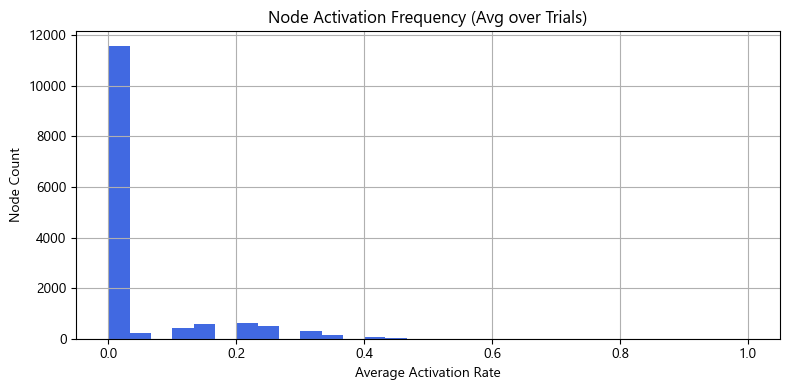

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(lAvgActivationsPerNode, bins=30, color='royalblue')
plt.title("Node Activation Frequency (Avg over Trials)")
plt.xlabel("Average Activation Rate")
plt.ylabel("Node Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretation of Node Activation Histogram

The histogram visualizes the average activation frequency of nodes across 20 cascade trials in the YouTube reply network.

🔍 Key Observations:
Most nodes (~11,500+) were rarely or never activated (activation rate ≈ 0), indicating that influence from seed users didn't reach the majority of the network.

A small portion of nodes show moderate activation rates (e.g., 0.1–0.4), suggesting they were occasionally influenced.

Very few or no nodes consistently activated in all trials (rate ≈ 1.0), highlighting the limited propagation reach from even high-centrality seed nodes.

📌 Implication:
The influence spread is localized, likely due to the network's structure (e.g., sparsity, clustering, or limited connectivity between communities). While top-degree nodes initiate some spread, most of the network remains uninfluenced unless more seeds or a higher activation probability are used.